# Homework 1 - Kacper Wilk - 2181714

## Overview
*What have I done for this project:*

- Creating the data
- Reading data
- Model Class
- Ensamble Class
- Testing
- Ploting and printing
- Animation

### Creating the data:

Not very much to say about this I believe. I chose the seed 12345 and created 100k samples for each robot. I didn't implement any solution for data preprocessing at this point, so the files loaded in by the read_data functions are "raw" samples produced by the simulation.

### Reading data:

I will keep this short. I've created the read_data function which reads the csv files with the help of numpy. The original csv files contain 100k samples but I limited them to 10k because google collab always stopped somewhere in range of sample number = 20k

Then read_data splits the dataset into X which is the input or rather the joint angles, and Y which is the output or rather the end-affector position + orientation.
The read_data function further limits the number of samples in X and Y according to the size variable, and splits the dataset into trainging and testing pairs of X,Y according to train_test_ratio variable.

At later point I added a randomize_dataset function as a means of preprocessing. In simulation the robot moves "continiously" so each sample will be correlated to the previous one. As the models only consider one sample at a time, its best to break this pattern in the dataset to improve generalization power, as shown later.

### Model class:

Making a good model class was very important to make the coding much more simple, and effective. In hindsight I wish I made the class even better with for example some kind of saving/loading feature. As the project grew I kept the model class compalible with the early tests by introducing default values for the variables, which after a while made a rather long list.

Creating the model:
Model is created according to model_param array. Its an array where each element represents a layer and each element value is the width of the layer. The first and last element of the array are input and output layers.

- Add input layer
- Add hidden layers, the activation function and inclusion of dropout dependent on the class parameters.
- Add output layer, always without activation function 
- Compile the model, loss function and optimizer are choosen by the class parameters.

Training the model:

Done by the train_and_evaluate class function. Which works in following way:

- Fit the model one epoch at a time.
- Evaluate the loss on training set.
- Evaluate the loss on the test set.
- Save both in "history" arrays.
- Repeat for every epoch.

I'm quite happy with how this allows to plot the performance over training time, and therefore get a feel for how quickly the model converges, and how long we should train it for.

### Ensamble class:

Ensambles are groups of smaller models which work together on finding the solution. They come of course in different implementations and forms.

In my implementation an ensamble works like this:

- Creation: Make n_models amount of models of type model_param. This means that every "submodel" is the same.
- Training: Train all submodels for one epoch, on a randomized and shrunk portion of the dataset. The shunkage is equal to (original size/n_models) meaning that a ensamble should have the same amount of training steps after the same number of epochs as a normal model, with the same initial dataset. Of course the randomizing can impact how good the model performs, therefore after this point I also started randomizing the whole dataset as a preprocessing step. Then calculate an average prediction of the ensamble for this epoch, and repeat the process until epoch limit. After the submodels are trained, the metamodel is trained next. Its a very small model, which hopefully has negligable training time. The metamodel is learning a function mapping the prediction of each submodel to end-affector-position. Metamodel a kind of weighted prediction. For each epoch of metamodel training, we record the loss. I realize now that this is not optimal, because the convergence rate is very deceiving as for first epoch of metamodel plot the submodels have already been trained for total-epochs each.

### Testing:
The interesting part...

Instead of writing it out here I've included notes, screenshots and comments above every test.
The overview of the tests performed in order are:
1. Comparing different model inputs
2. Comparing different model outputs
3. Randomized vs unrandomized datasets.
4. Testing different model structures / types, including individual vs ensambles.
5. Testing different model sizes
6. Testing different activation functions + dropout 
7. Hyperparameter optimization
8. Different optimizers and loss functions
9. Comparing the model performance for r2, r3 and r5 robots.
10. Inverse kinematics and mujoco for r5. Bonus: Increasing the amount of samples in dataset.

### Ploting:
Not much to say.

I mostly used loss vs epochs plot for most tests and models. Overall I believe its a good way to show relative performance and convergence speed. But, at the same time in the case of ensamble vs individual it shows a very unrealistic picture because of my mistake. 

I also tried to plot true values vs predicted values in test 9. Which while it seems like a quite interesting plot, it doesn't provide that much information, maybe outside of exposing extreme outliers.

On test 8 I used a bar diagram for the last epoch only, mostly to skip writing code for converting to correct loss type, I think it does its job well enough. 

### Animation:
My first experience with Mujoco, was suprisingly good. 
The tutorial projects were a very big help:

https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb#scrollTo=z-zoBCuBv2Xi

https://github.com/google-deepmind/mujoco/blob/main/model/humanoid/humanoid.xml

https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/LQR.ipynb

I've modeled the robot by putting in the X,Y values in the initial conditions and adjusting model parameters until the more or less matched what I saw visually. 

I've added a very simple P/PI controller for each joint, by trial and error.

To implement the inverse kinematics I've made my own implementation of Newton–Raphson based on: 

https://en.wikipedia.org/wiki/Inverse_kinematics



# Imports

In [11]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib
import math
from matplotlib import pyplot as plt
import time

KeyboardInterrupt: 

In [ ]:
#Function for reading the csv and splitting them into train/test X/Y arrays
def read_data(robot_model, size=1000, train_test_ratio = 0.7):
  #r2
  if robot_model == 1:
    path = "r2_seed12345_step100000.csv"
    df = pd.read_csv(path,sep=";",header=0)
    df = df.dropna()

    df = df[0:10000]

    X = df[["j0", "j1", "sin(j0)","sin(j1)", "cos(j0)", "cos(j1)"]]
    Y = df[["ft_x", "ft_y", "ft_qw", "ft_qz"]]

  #r3
  if robot_model == 2:
    path = "r3_seed12345_step100000.csv"
    df = pd.read_csv(path,sep=";",header=0)
    df = df.dropna()
    df = df[0:10000]

    X = df[["j0", "j1", "j2", "sin(j0)","sin(j1)","sin(j2)", "cos(j0)", "cos(j1)","cos(j2)"]]
    Y = df[["ft_x", "ft_y", "ft_qw", "ft_qz"]]

  #r5
  if robot_model == 3:
    path = "r5_seed12345_step100000.csv"
    df = pd.read_csv(path,sep=";",header=0)
    df = df.dropna()
    df = df[0:10000]

    X = df[["j0", "j1", "j2", "j3", "j4",
            "sin(j0)","sin(j1)","sin(j2)","sin(j3)","sin(j4)",
            "cos(j0)", "cos(j1)", "cos(j2)", "cos(j3)", "cos(j4)"]]

    Y = df[["ft_x", "ft_y", "ft_z", "ft_qw", "ft_qx", "ft_qy", "ft_qz"]]

  #Limit size of data set and add train/test split.
  X_train = X[0:int(train_test_ratio*size)]
  X_test = X[int(train_test_ratio*size):size]

  Y_train = Y[0:int(train_test_ratio*size)]
  Y_test = Y[int(train_test_ratio*size):size]

  return X_train,X_test,Y_train,Y_test

In [ ]:
class Model():
  def __init__(self, model_param, lr, momentum, h_activation="leaky", leaky_rate=0.1, dropout=False, dropout_rate=0.5, optimizer = "sgd", loss = "mse", weight_decay = 0.001, lr_decay = 0.95, lr_step_per_decay = 30): #n_sample/batch_size = n_steps_per_epoch

    #Log
    self.training_history = []
    self.testing_history = []
    self.current_epoch = 0

    #Model Structure
    self.model_param = model_param
    self.hidden = model_param[1:-1]
    self.dropout = dropout
    self.h_activation = h_activation
    self.optimizer = optimizer
    self.loss = loss

    self.model = tf.keras.Sequential()

    #Hyperparameters
    self.lr = lr
    self.momentum = momentum
    self.weight_decay = weight_decay
    self.leaky_rate = leaky_rate
    self.dropout_rate = dropout_rate
    self.lr_decay = lr_decay
    self.lr_step_per_decay = lr_step_per_decay

    #Create the model
    self.create_model()


  def create_model(self):

    #Input layer
    self.model.add(tf.keras.layers.Input(shape=(self.model_param[0],)))

    self.create_hidden()

    #Output layer
    self.model.add(tf.keras.layers.Dense(self.model_param[-1]))

    self.compile_model()

    return None

  def compile_model(self):

    #------------Optimizers-------------
    if self.optimizer == "sgd":
      opt = tf.keras.optimizers.SGD(learning_rate=self.lr, momentum=self.momentum)

    elif self.optimizer == "a_sgd":
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=self.lr, decay_steps=self.lr_step_per_decay, decay_rate=self.lr_decay)
      opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=self.momentum)

    elif self.optimizer == "adam":
      opt = tf.keras.optimizers.Adam(learning_rate=self.lr)

    elif self.optimizer == "rms_prop":
      opt = tf.keras.optimizers.RMSprop(learning_rate=self.lr)

    else:
      raise ValueError("Invalid optimizer")


    #------------Loss Functions----------------
    if self.loss == "mse":
      loss=tf.keras.losses.MSE

    elif self.loss == "msle":
      loss=tf.keras.losses.MeanSquaredLogarithmicError()

    elif self.loss == "mae":
      loss=tf.keras.losses.MeanAbsoluteError()

    elif self.loss == "huber":
      loss=tf.keras.losses.Huber()

    else:
      raise ValueError("Invalid loss function")

    #------------------------------------------
    self.model.compile(loss=loss, optimizer=opt)
    return None


  #Train the model on training set, for each epoch also evaluate for both training set and test set.
  def train_and_evaluate(self, X_train, X_test, Y_train, Y_test, epochs, batch_size):
    for epoch in range(epochs):
      self.model.fit(X_train,Y_train,batch_size=batch_size,verbose=0) #Train

      training_loss = self.model.evaluate(X_train,Y_train, batch_size=batch_size,verbose=0) #Evaluate training
      test_loss = self.model.evaluate(X_test,Y_test, batch_size=batch_size,verbose=0) #Evaluate test

      self.training_history.append(training_loss)
      self.testing_history.append(test_loss)

      self.current_epoch += 1

    return None

  def create_hidden(self):
    if self.dropout:
      if self.h_activation == "leaky":
        for i in range(len(self.hidden)):
          self.model.add(tf.keras.layers.Dense(self.hidden[i], tf.keras.layers.LeakyReLU(negative_slope=self.leaky_rate)))
          if i%2==1: #Randomly choose to add dropout every odd layer
            self.model.add(tf.keras.layers.Dropout(rate=self.dropout_rate/i))

      else:
        for i in range(len(self.hidden)):
          self.model.add(tf.keras.layers.Dense(self.hidden[i], activation=self.h_activation))
          if i%2==1:
            self.model.add(tf.keras.layers.Dropout(rate=self.dropout_rate/i))

    if not self.dropout:
      if self.h_activation == "leaky":
        for i in range(len(self.hidden)):
          self.model.add(tf.keras.layers.Dense(self.hidden[i], tf.keras.layers.LeakyReLU(negative_slope=self.leaky_rate)))

      else:
        for i in range(len(self.hidden)):
          self.model.add(tf.keras.layers.Dense(self.hidden[i], activation=self.h_activation))


In [ ]:
class Ensamble(): # A group of models
  def __init__(self, model_param, lr, momentum, n_models, n_outputs=2):

    self.models = []
    self.n_models = n_models
    self.avg_testing_history = []
    self.meta_model = Model([n_models*2, 64,32,16,8, n_outputs], lr, momentum)

    self.create_models(model_param, lr, momentum, n_models)

  def create_models(self, model_param, lr, momentum,n_models):
    for i in range(n_models):
      self.models.append(Model(model_param, lr, momentum))
    return None

  def train_and_evaluate(self, X_train, X_test, Y_train, Y_test, epochs, batch_size):
    for epoch in range(epochs):
      #Train all models
      for model in self.models:
        #Randomize the data for each model to have different models.
        random_index = np.random.permutation(X_train.index)
        X = X_train.loc[random_index]
        Y = Y_train.loc[random_index]

        #Shrink the data sets by the amount of member models to make it a fair comparison to the individual models?
        X = X.iloc[0:int(len(X)/self.n_models)]
        Y = Y.iloc[0:int(len(Y)/self.n_models)]

        model.train_and_evaluate(X, X_test, Y, Y_test, 1, batch_size)

      avg_prediction = self.get_avg_prediction(X_test)
      avg_loss = np.mean((avg_prediction - Y_test)**2)
      self.avg_testing_history.append(avg_loss)

    #Train the meta-model after base-models have been trained
    train_predictions = [model.model.predict(X_train) for model in self.models]
    train_predictions = np.hstack(train_predictions)
    test_predictions = [model.model.predict(X_test) for model in self.models]
    test_predictions = np.hstack(test_predictions)
    self.__train_and_evaluate_meta(train_predictions, test_predictions, Y_train, Y_test, epochs, batch_size)


  def __train_and_evaluate_meta(self, X_train, X_test, Y_train, Y_test, epochs, batch_size):
    for epoch in range(epochs):
      self.meta_model.model.fit(X_train, Y_train, batch_size=batch_size, verbose=0) #Train

      training_loss = self.meta_model.model.evaluate(X_train, Y_train, batch_size=batch_size, verbose=0) #Evaluate training
      test_loss = self.meta_model.model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0) #Evaluate testing

      self.meta_model.training_history.append(training_loss)
      self.meta_model.testing_history.append(test_loss)

    return None

  def get_avg_prediction(self, X_test):
    predictions = [model.model.predict(X_test) for model in self.models]
    return np.mean(predictions, axis=0)

  def get_meta_prediction(self, X_test):
    predictions = [model.model.predict(X_test) for model in self.models]
    return self.meta_model.model.predict(predictions)




In [ ]:
def plot_array_of_histories(array, title, labels, ylim=None):
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  if ylim != None:
    plt.ylim(0,ylim)

  for i in range(len(array)):
    plt.plot(array[i], label=labels[i])


  plt.legend()
  plt.show()

#Plot a graph test dataset, vs model predictions.
def plot_model_predictions(X,Y,model):
  plt.figure()
  plt.title("XY Coordinates")
  plt.plot(Y["ft_x"], Y["ft_y"], ".", label="Data")
  plt.plot(model(X)[:,0], model(X)[:,1], ".", label="Data")

In [ ]:
def randomize_datasets(X_train, X_test, Y_train, Y_test, r5 = False):
  np.random.seed(1)

  random_index_train = np.random.permutation(X_train.index)
  random_index_test = np.random.permutation(X_test.index)

  random_X_train = X_train.loc[random_index_train]
  random_Y_train = Y_train.loc[random_index_train]

  random_X_test = X_test.loc[random_index_test]
  random_Y_test = Y_test.loc[random_index_test]

  if r5:
    random_Y_train = random_Y_train[["ft_x", "ft_y", "ft_z"]]
    random_Y_test = random_Y_test[["ft_x", "ft_y", "ft_z"]]

  else:
    random_Y_train = random_Y_train[["ft_x", "ft_y"]]
    random_Y_test = random_Y_test[["ft_x", "ft_y"]]

  return random_X_train, random_X_test, random_Y_train, random_Y_test

# Test 1: Comparing different inputs for the r2 robot.

Inputs tested:
- Angles
- Sines
- Cosines
- Sines & cosines
- All together

Result:
- All togetherm and sines+cosines -> winners.
- Quite equal performance and low noise on both.
- Sines and Cosines do individually really poorly.


Adding more inputs, doesn't "actually" provide any new information for us humans because we can simply calculate the sines and cosines "manually".

The model, however doesn't have this ability, and therefore it treats the sines and cosines as distinct inputs. 

For me it is expected and intuitive that increasing the amount of inputs improves the performance of the model, however I don't think I'm able to explain it in a more formal way at this point.

It makes sense that only sines and only cosines do poorly because they are missing the other half of the information about the joints angle. (You dont know which part of unit circle you are in. if sin(j0) = 0 you could be at  pi/2 or at 3pi/2)

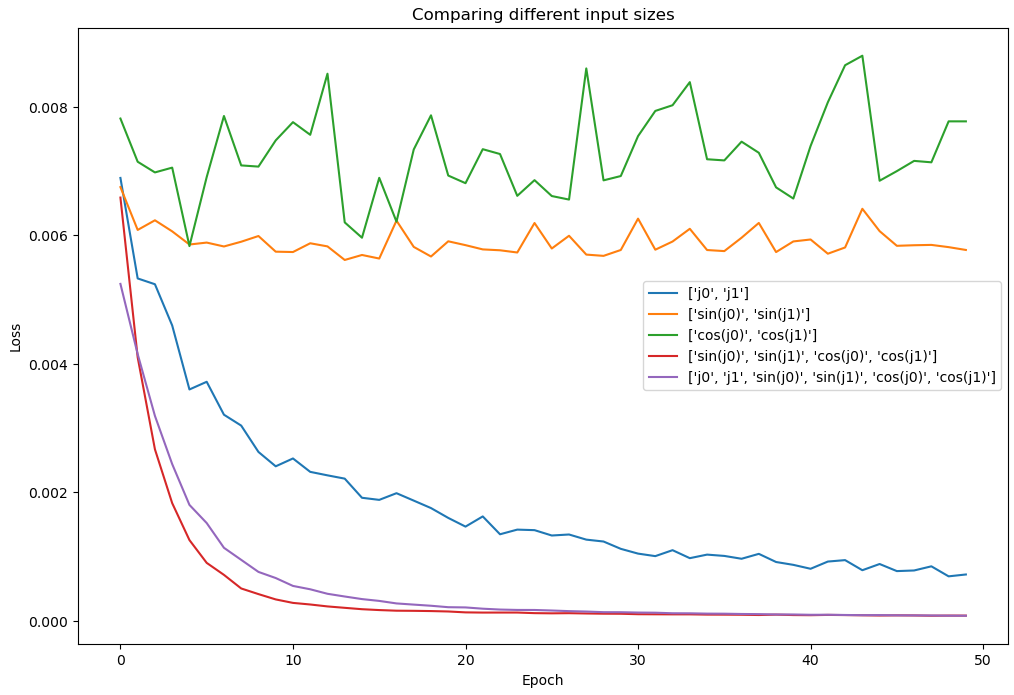

In [ ]:
#Compare different inputs for r2.

if False:
  X_train,X_test,Y_train,Y_test = read_data(1)
  angles = ["j0","j1"]
  sines = ["sin(j0)","sin(j1)"]
  cosines = ["cos(j0)","cos(j1)"]
  sines_cosines = ["sin(j0)","sin(j1)","cos(j0)","cos(j1)"]

  inputs_training = [X_train[angles], X_train[sines], X_train[cosines], X_train[sines_cosines], X_train]
  inputs_testing = [X_test[angles], X_test[sines], X_test[cosines], X_test[sines_cosines], X_test]

  models = [Model([inputs_training[i].shape[1],256,128,64,32,16,2], 0.1, 0.05) for i in range(len(inputs_training))]

  for i in range(len(inputs_training)):
    models[i].train_and_evaluate(inputs_training[i],inputs_testing[i], Y_train[["ft_x", "ft_y"]], Y_test[["ft_x", "ft_y"]], 50, 16)

  plt.figure(figsize=(12, 8))
  plt.title("Comparing different input sizes")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  for i in range(len(inputs_training)):
    plt.plot(models[i].testing_history, label=f"{inputs_testing[i].columns.tolist()}")


  plt.legend()


# Test 2: Compare different outputs for r2.
Tested:
- Cartesian
- Orientation
- Both

Results:
- Orientation seems to initially increase the loss alot, but the models overcome this with training.
- It seems a little weird, that the loss is initially so low for the cartesian output. I would guess its because of the initial weights producing outputs close to 0 and difference in "range" of cartesian [-0.3, 0.3] vs orientation [-pi/2, pi/2].
- In zoomed picture, we can see that the loss is smallest and equal for cartesian and orientation, but more noisy for orientation. 
- Curiously the combination seemingly performed worse. This is because the model has now to more values which contribute to the loss. Even if each individual loss (hopefully) is smaller than before the total for all states is higher. This is possibly not a very fair comparison.

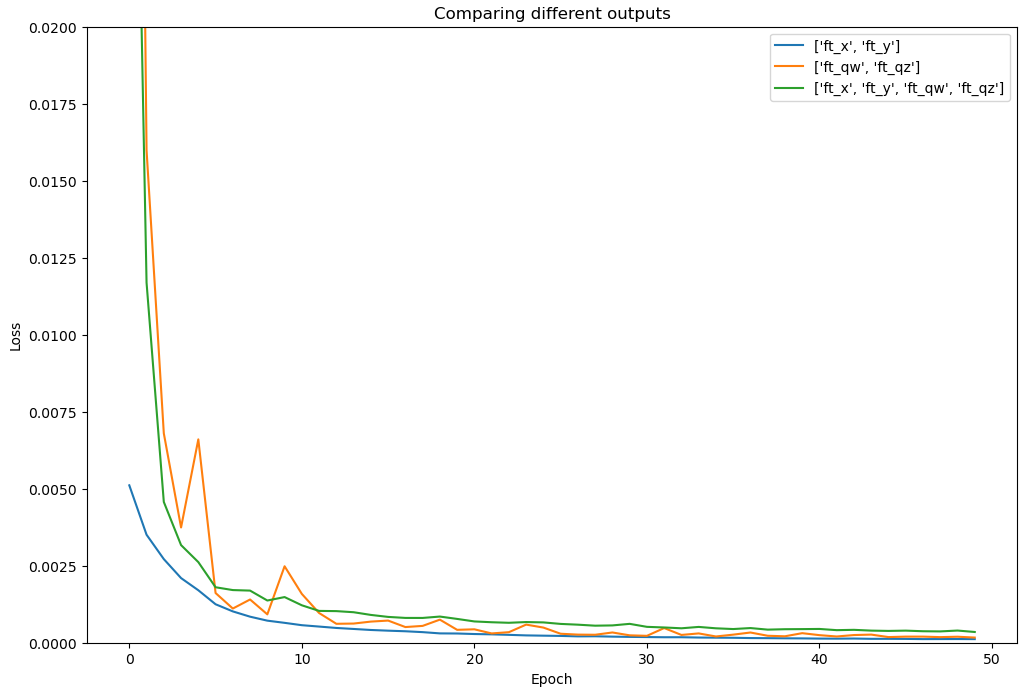

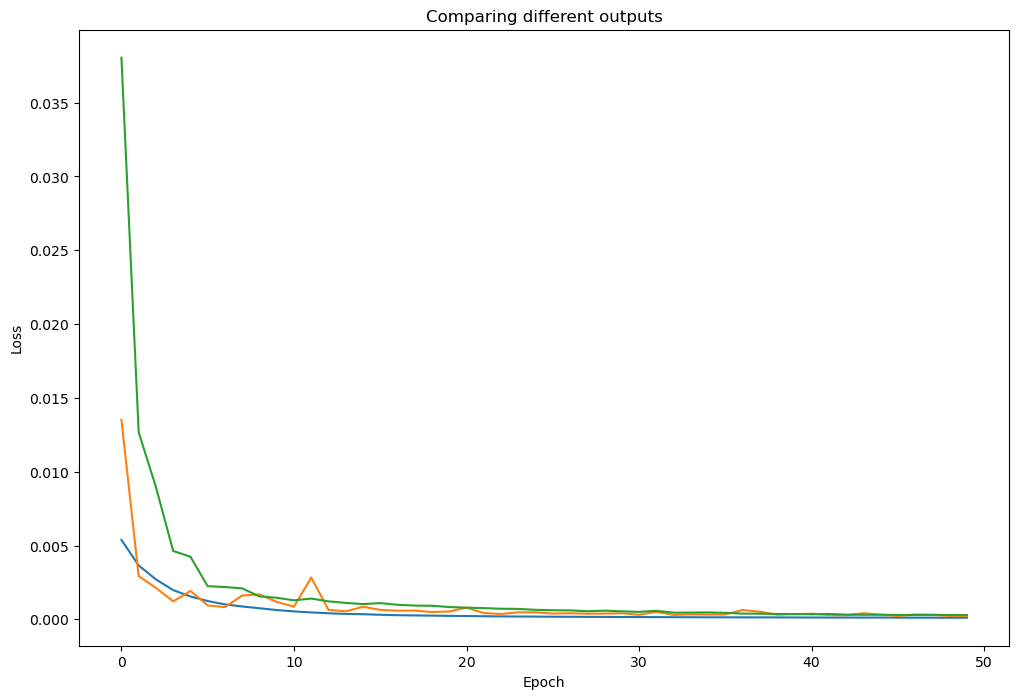

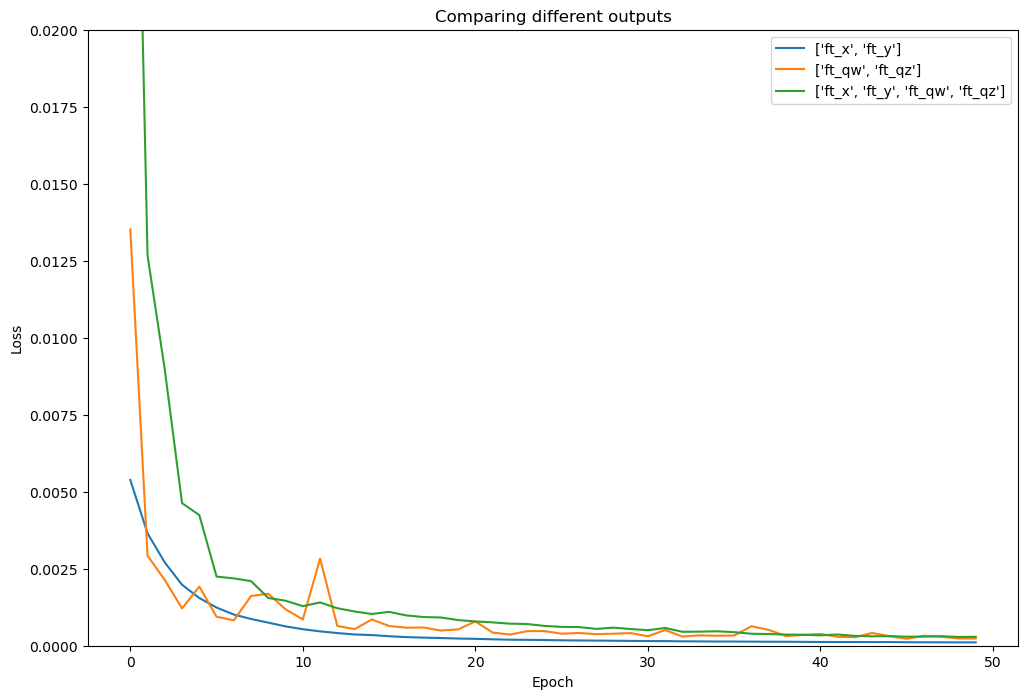

In [ ]:
#Test 2: Different outputs
if True:
  X_train,X_test,Y_train,Y_test = read_data(1)
  cartesian = ["ft_x", "ft_y"]
  orientation = ["ft_qw", "ft_qz"]

  outputs_training = [Y_train[cartesian], Y_train[orientation], Y_train]
  outputs_testing = [Y_test[cartesian], Y_test[orientation], Y_test]

  models = [Model([6,256,128,64,32,16,outputs_training[i].shape[1]], 0.1, 0.05) for i in range(len(outputs_training))]

  for i in range(len(outputs_training)):
    models[i].train_and_evaluate(X_train,X_test, outputs_training[i], outputs_testing[i], 50, 16)

  plt.figure(figsize=(12, 8))
  plt.title("Comparing different outputs")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  for i in range(len(outputs_training)):
    plt.plot(models[i].testing_history, label=f"{outputs_training[i].columns.tolist()}")


  plt.figure(figsize=(12, 8))
  plt.title("Comparing different outputs")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.ylim(0,0.02) #Zoom

  for i in range(len(outputs_training)):
    plt.plot(models[i].testing_history, label=f"{outputs_training[i].columns.tolist()}")

  plt.legend()



# Test 3: Compare randomized dataset vs unrandomized.
Tested:
- Unrandomized
- Randomized
- random seed = [1,2]

Results:
It seems randomized sets are better. This is consistent with the theory where generally processing of datasets (scaling, transforming, rotating, randomizing) increases the generalization power of the neural network.

This is quite intuitive. Because we will most likely get a much more represenative dataset of the whole work-space of the robot.


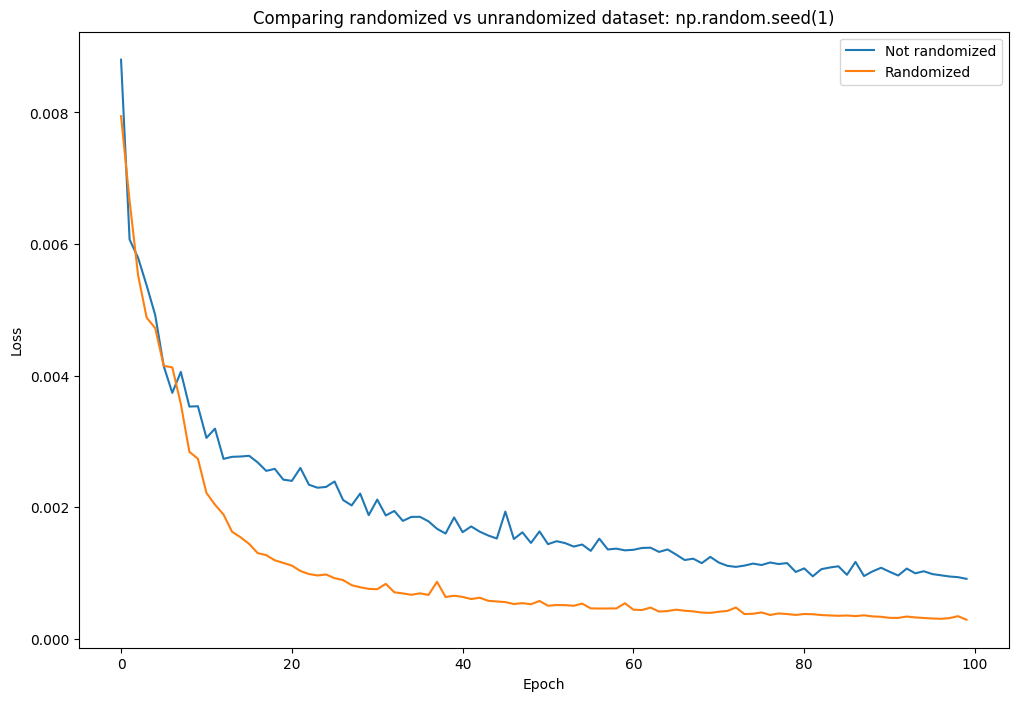

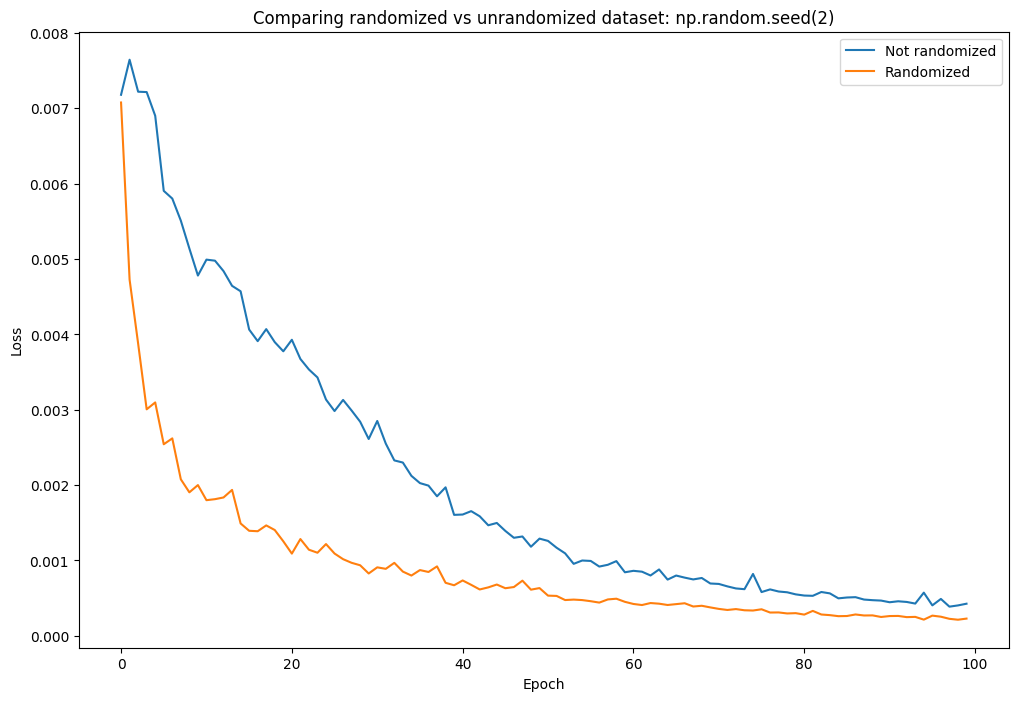

In [ ]:
#Test 3: Randomize the order of the dataset.

if False:
  X_train,X_test,Y_train,Y_test = read_data(1)

  model_default = Model([6,256,128,64,32,16,2], 0.1, 0.05)
  model_randomized = Model([6,256,128,64,32,16,2], 0.1, 0.05)

  model_default.train_and_evaluate(X_train,X_test, Y_train[["ft_x", "ft_y"]], Y_test[["ft_x", "ft_y"]], 100, 16)

  X_train,X_test,Y_train,Y_test = randomize_datasets(X_train,X_test,Y_train,Y_test)
  model_randomized.train_and_evaluate(X_train, X_test, Y_train, Y_test, 100, 16)

  plt.figure(figsize=(12, 8))
  plt.title("Comparing randomized vs unrandomized dataset")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(model_default.testing_history, label="Not randomized")
  plt.plot(model_randomized.testing_history, label="Randomized")
  plt.legend()



# Test 4: Test different network structures
## Tested:
Shallow, Shallowish, Deep, 5x Ensamble, 10x Ensamble.

## Results:
###Times in seconds after training for 100 epochs:

- Deep 45.07,
- Shallowish 39.83,
- Shallow 45.39
- 5x 270.29,
- 10x 460.13

Big difference between models and ensambles at 100 epochs... Creating models / overhead is costly? Keep in mind the amount of trainable parameters is roughly equal between the ensambles and models. 
It seems that the amount of trainable parameters doesn't have as big of an impact on the training time, as I previously imagined.

### 5x vs 10x ensambles and average predictions vs metalearner predictions.

Metalearner beats average. 
Unfortunatly, I didn't implement a solution to exclude metalearner time from training time to fairly compare avg vs meta. But since the metalearner model is very small it (hopefully) has negligable impact. With that in mind, the metalearners seem to perform alot better than averages.

However the comparison between 5x submodels and 10x submodels should be fair. 
There we can clearly see that 10x avg is doing very poorly compared to 5x average. Why? I cannot find a good explanation...
We also see that for the metalearners the loss is practically identical for 5x vs 10x and after time adjustment the 5x is a clear winner. According to the theory making the ensamble bigger has diminishing returns, so the result is not too suprising. I would expect a little bigger difference between the unadjusted times though...
Its also worth adding that the average prediction seems to still be improving, while the metalearner seems quite firmly settled after 30 epochs.  

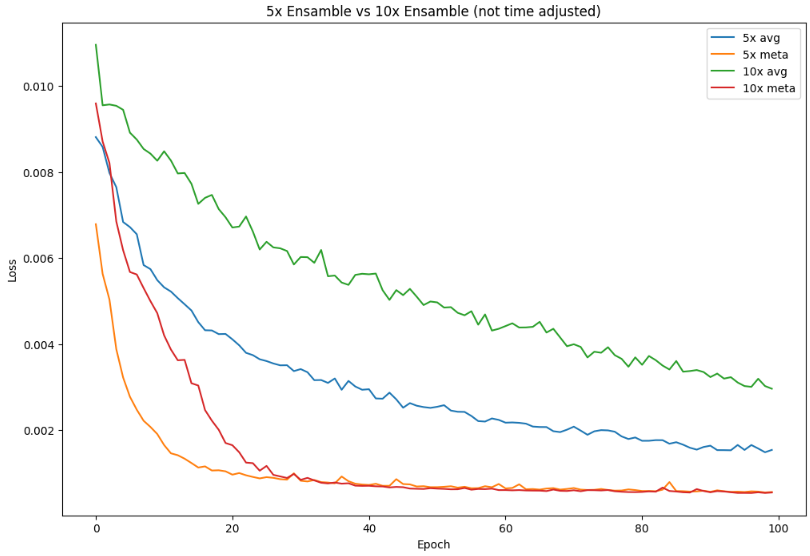

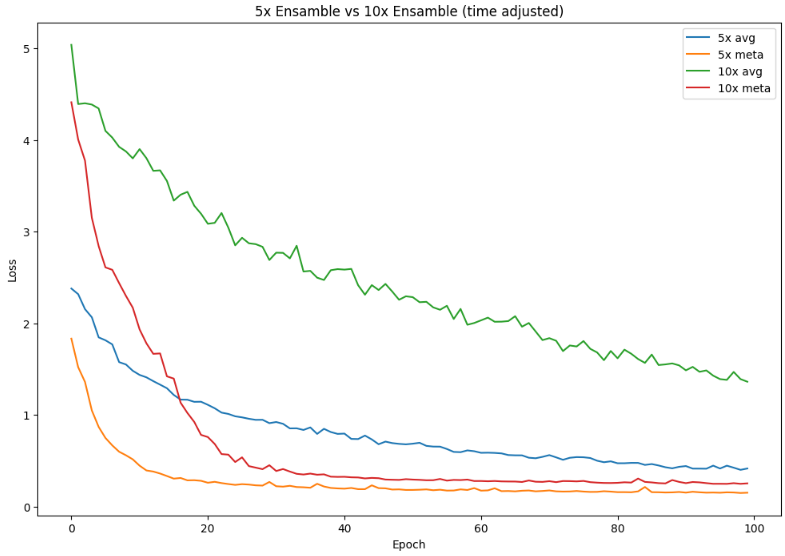

# Performace: Models vs Ensambles

Deep networks seem to be a winner both in before and after time adjustment.
Deeper networks perform better than shallow ones.
Ensambles outperform shallow networks before time adjusments but underperform after.

**Interestingly 5x metalearner has really quick convergence. Maybe thats the redeeming quality of the ensambles?**

## Conclusion:
I'm really confident that deep network is the best structure for this task.
I'm going however to try one more round of training, with variable epoch lenghts for different models to see how ensambles perform after time adjustment.
Keep in mind that for the ensambles training sets are shrunk by amount of submodels to make the total amount of training roughly equal to an individual model

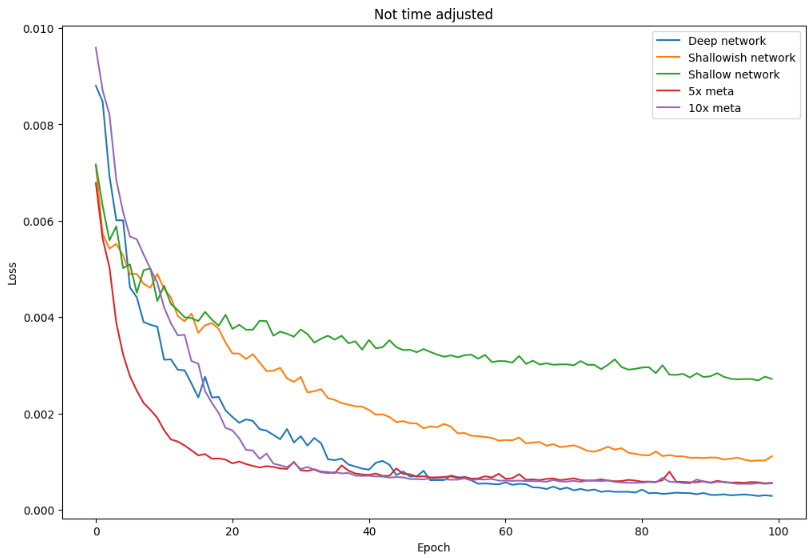

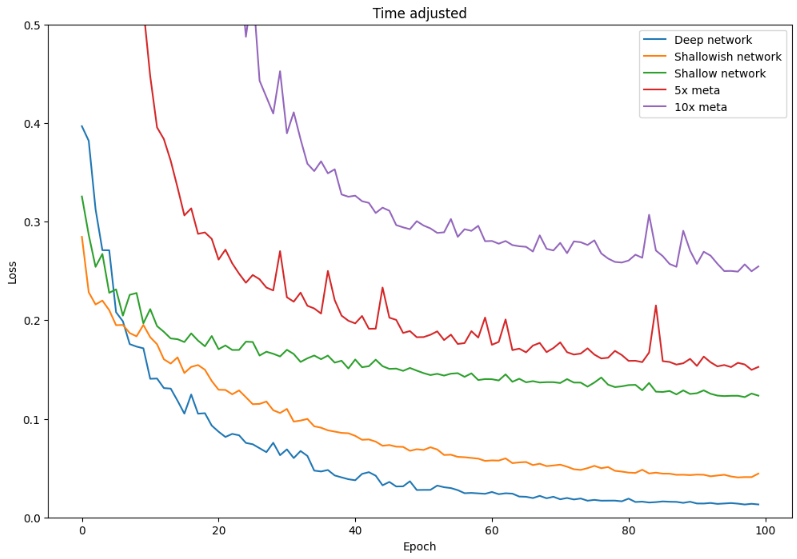

# Variable epochs:
*After, playing around with different different epoch lenghts, I realized I'm
not able to recreate the fast convergence of ensamble models for lower epoch lenghts. At this point im not really sure why that is. The random initial weights? The random slicing and shrinking of the dataset for ensambles? Some different part of the model like optimizer? A bug in the code?
It's really hard to say at this point.*

After sleeping on the problem I remembered that the ensamble submodels are trained first, then the metamodel is trained, which performence of we see in the graph. This explains the worse performance because for 5x ensamble we train each submodel 20 times then the metamodel 20 times.
I imagine we could save some negligable time by training submodels for 100 epochs and metamodel for 20 epochs instead of 100.
But in the end I do think that deep network is a better solution for this task given much shorter training time.


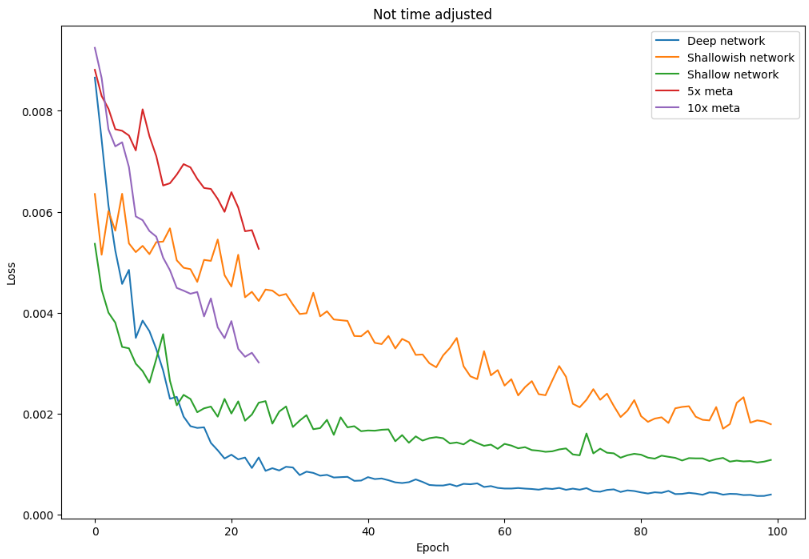

In [ ]:
#Test 4 Test different network structures.

if False:
  d1,d2,d3,d4 = read_data(1)
  X_train,X_test,Y_train,Y_test = randomize_datasets(d1,d2,d3,d4)

  deep_network = Model([6,256,128,64,32,16,8,2], 0.1, 0.05) #45,628 params
  shallowish_network = Model([6,300,143,2], 0.1, 0.05) #45473 params
  shallow_network = Model([6,5050,2], 0.1, 0.05) #45494 params
  ensamble_5 = Ensamble([6,127,60,8,2], 0.1, 0.05, 5,2) #45585 params + negligable meta-network params
  ensamble_10 = Ensamble([6,64,48,16,8,2], 0.1, 0.05, 10,2) #45480 + negligable meta-network params

  models = [deep_network, shallowish_network, shallow_network]
  ensambles = [ensamble_5, ensamble_10]
  times_models = []
  times_ensambles = []
  time_adjusted_histories = []

  epochs = [100,100,100,100,100] #Non variable
  #epochs = [100,100,100,25,25] #Variable
  j = 0

  for model in models:
    start_time = time.time()
    model.train_and_evaluate(X_train, X_test, Y_train, Y_test, epochs[j], 16)
    j += 1
    elapsed_time = time.time() - start_time

    times_models.append(elapsed_time)
    time_adjusted_histories.append([model.testing_history[i] * elapsed_time for i in range(len(model.testing_history))])

  for ensamble in ensambles:
    start_time = time.time()
    ensamble.train_and_evaluate(X_train, X_test, Y_train, Y_test, epochs[j], 16)
    j += 1
    elapsed_time = time.time() - start_time
    times_ensambles.append(elapsed_time)


    time_adjusted_histories.append([ensamble.avg_testing_history[i] * elapsed_time for i in range(len(ensamble.avg_testing_history))])
    time_adjusted_histories.append([ensamble.meta_model.testing_history[i] * elapsed_time for i in range(len(ensamble.meta_model.testing_history))])


  #------------------------------------------PLOTS AND RESULTS ---------------------------------------------------------

  print(times_models)
  print(times_ensambles)

  #Print Time Adjusted 5x vs 10x
  plt.figure(figsize=(12, 8))
  plt.title("5x Ensamble vs 10x Ensamble (time adjusted)")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  labels1 = ["5x avg", "10x avg"]
  labels2 = ["5x meta","10x meta"]


  plt.plot(time_adjusted_histories[3], label=labels1[0])
  plt.plot(time_adjusted_histories[4], label=labels2[0])
  plt.plot(time_adjusted_histories[5], label=labels1[1])
  plt.plot(time_adjusted_histories[6], label=labels2[1])


  plt.legend()

  #Not time adjusted 10x vs 5x
  plt.figure(figsize=(12, 8))
  plt.title("5x Ensamble vs 10x Ensamble (not time adjusted)")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  labels1 = ["5x avg", "10x avg"]
  labels2 = ["5x meta","10x meta"]

  plt.plot(ensambles[0].avg_testing_history, label=labels1[0])
  plt.plot(ensambles[0].meta_model.testing_history, label=labels2[0])
  plt.plot(ensambles[1].avg_testing_history, label=labels1[1])
  plt.plot(ensambles[1].meta_model.testing_history, label=labels2[1])



  plt.legend()

  plt.figure(figsize=(12, 8))
  plt.title("Not time adjusted")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")


  labels_m = ["Deep network", "Shallowish network", "Shallow network"]
  labels_e = ["5x meta", "10x meta"]

  plt.plot(models[0].testing_history, label=labels_m[0])
  plt.plot(models[1].testing_history, label=labels_m[1])
  plt.plot(models[2].testing_history, label=labels_m[2])

  plt.plot(ensambles[0].meta_model.testing_history, label=labels_e[0])
  plt.plot(ensambles[1].meta_model.testing_history, label=labels_e[1])

  plt.legend()

  plt.figure(figsize=(12, 8))
  plt.title("Time adjusted")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.ylim(0,0.5)

  labels_m = ["Deep network", "Shallowish network", "Shallow network"]
  labels_e = ["5x meta", "10x meta"]

  plt.plot(time_adjusted_histories[0], label=labels_m[0])
  plt.plot(time_adjusted_histories[1], label=labels_m[1])
  plt.plot(time_adjusted_histories[2], label=labels_m[2])

  plt.plot(time_adjusted_histories[4], label=labels_e[0])
  plt.plot(time_adjusted_histories[6], label=labels_e[1])

  plt.legend()





# Test 5: Different network sizes
## Tested:
From 12 thousand to 11 million trainable parameters. See code below for exact structures.

## Results:
Very small differences between the networks. The 2,8 million network is an odd one, worse performance then even 11 million network. Very small differences for the rest.

Times in seconds from smallest model to largest: 47.22, 44.59, 51.24, 69.20, 170.57, 703.92

The 45k networks was slightly quicker to train than the 12k... Maybe some kind of data cache from other runs?

## No clear winner in this test, clear losers: 11mil, 2.8mil

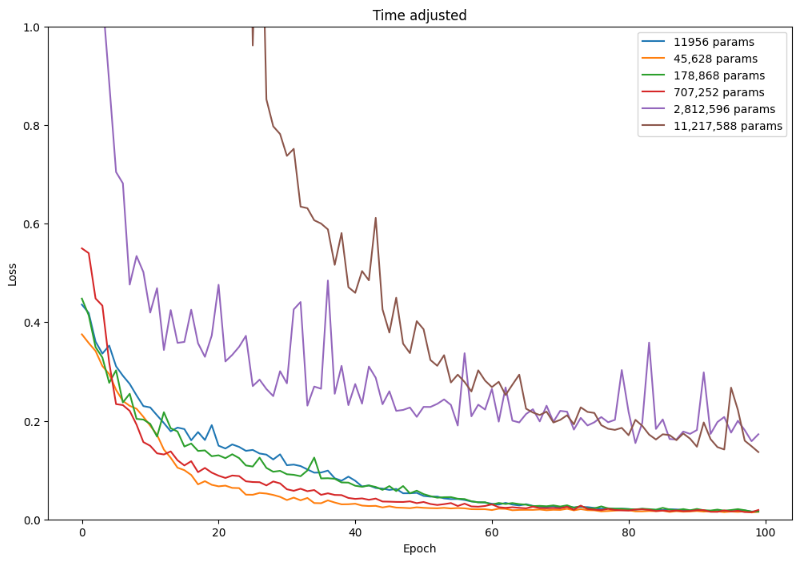

In [ ]:
#Test 5 networks sizes

if False:
  d1,d2,d3,d4 = read_data(1)
  X_train,X_test,Y_train,Y_test = randomize_datasets(d1,d2,d3,d4)

  m1 = Model([6,128,64,32,16,8,2], 0.1, 0.05) #11956 params
  m2 = Model([6,256,128,64,32,16,8,2], 0.1, 0.05) #45,628 params
  m3 = Model([6,512,256,128,64,32,16,8,2], 0.1, 0.05) #178,868 params
  m4 = Model([6,1024,512,256,128,64,32,16,8,2], 0.1, 0.05) #707,252 params
  m5 = Model([6,2048,1024,512,256,128,64,32,16,8,2], 0.1, 0.05) #2,812,596 params
  m6 = Model([6,4096,2048,1024,512,256,128,64,32,16,8,2], 0.1, 0.05) #11,217,588 params

  models = [m1,m2,m3,m4,m5,m6]
  times = []
  time_adj = []

  for m in models:
    start_time = time.time()
    m.train_and_evaluate(X_train, X_test, Y_train, Y_test, 100, 16)
    elapsed_time = time.time() - start_time
    times.append(elapsed_time)
    time_adj.append([m.testing_history[i] * elapsed_time for i in range(len(m.testing_history))])

  # -------------- Results ------------------------

  labels = ["11956 params","45,628 params","178,868 params","707,252 params","2,812,596 params","11,217,588 params"]
  print(times)

  plt.figure(figsize=(12, 8))
  plt.title("Not time adjusted")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  for m in range(len(models)):
    plt.plot(models[m].testing_history, label = labels[m])
  plt.legend()

  plt.figure(figsize=(12, 8))
  plt.title("Time adjusted")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.ylim(0,1)
  for m in range(len(models)):
    plt.plot(time_adj[m], label = labels[m])
  plt.legend()


# Test 6: Hidden Layer Optimization

## Tested:
6 different hidden layer types. See legend.

Result: Sigma function is bad, leaky is great, thats expected. Why is dropout doing so bad? More testing is needed.

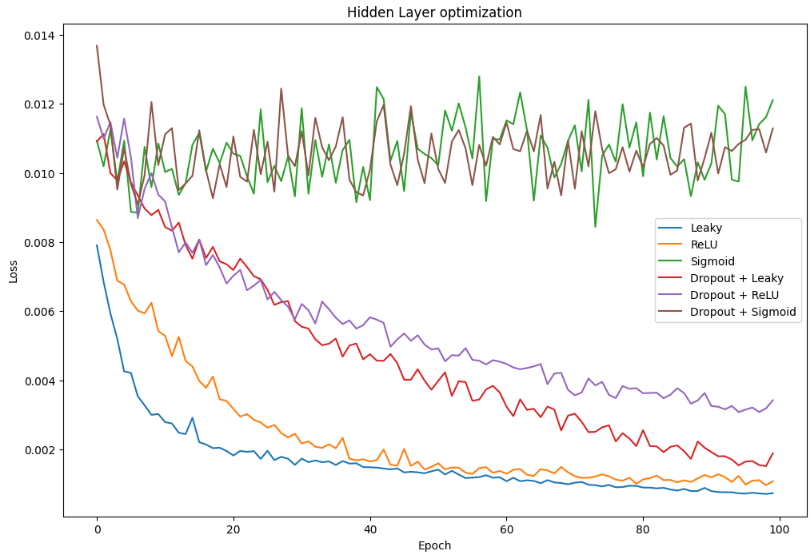

In [ ]:
#Test 6 Hidden Layer optimization

if False:
  d1,d2,d3,d4 = read_data(1)
  X_train,X_test,Y_train,Y_test = randomize_datasets(d1,d2,d3,d4)

  leaky = Model([6,256,128,64,32,16,8,2], 0.1, 0.05)
  relu = Model([6,256,128,64,32,16,8,2], 0.1, 0.05, hidden="relu")
  sigma = Model([6,256,128,64,32,16,8,2], 0.1, 0.05, hidden="sigmoid")
  dropout_leaky = Model([6,256,128,64,32,16,8,2], 0.1, 0.05, dropout=True)
  dropout_relu = Model([6,256,128,64,32,16,8,2], 0.1, 0.05, hidden="relu", dropout=True)
  dropout_sigma = Model([6,256,128,64,32,16,8,2], 0.1, 0.05, hidden="sigmoid", dropout=True)


  leaky.train_and_evaluate(X_train, X_test, Y_train, Y_test, 100, 16)
  relu.train_and_evaluate(X_train, X_test, Y_train, Y_test, 100, 16)
  sigma.train_and_evaluate(X_train, X_test, Y_train, Y_test, 100, 16)
  dropout_leaky.train_and_evaluate(X_train, X_test, Y_train, Y_test, 100, 16)
  dropout_relu.train_and_evaluate(X_train, X_test, Y_train, Y_test, 100, 16)
  dropout_sigma.train_and_evaluate(X_train, X_test, Y_train, Y_test, 100, 16)

  plt.figure(figsize=(12, 8))
  plt.title("Hidden Layer optimization")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.plot(leaky.testing_history, label = "Leaky")
  plt.plot(relu.testing_history, label = "ReLU")
  plt.plot(sigma.testing_history, label = "Sigmoid")
  plt.plot(dropout_leaky.testing_history, label = "Dropout + Leaky")
  plt.plot(dropout_relu.testing_history, label = "Dropout + ReLU")
  plt.plot(dropout_sigma.testing_history, label = "Dropout + Sigmoid")
  plt.legend()

# Test 6.2 Further dropout testing

- Tried to optimize the values of dropout_rate but unable to beat the performance of non dropout network.


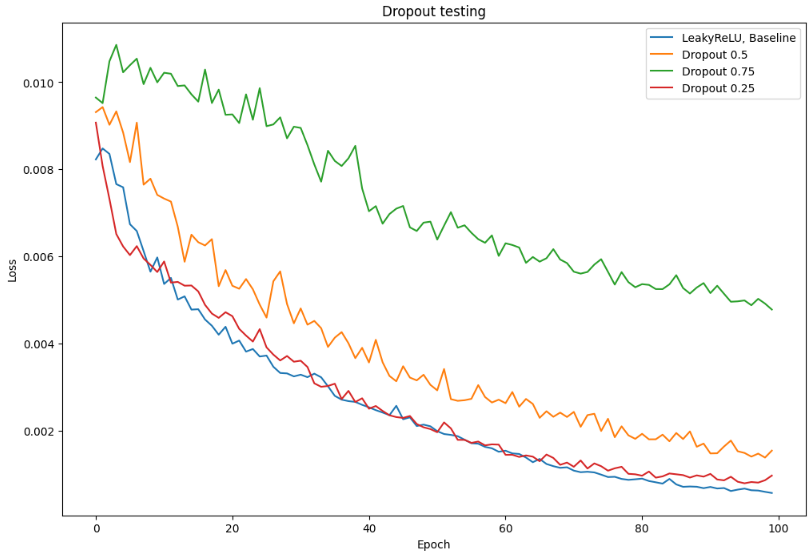

In [ ]:
#Test 6.2 Dropout

if False:
  d1,d2,d3,d4 = read_data(1)
  X_train,X_test,Y_train,Y_test = randomize_datasets(d1,d2,d3,d4)

  m = Model([6,256,128,64,32,16,8,2], 0.1, 0.05) #Baseline
  d1 = Model([6,256,128,64,32,16,8,2], 0.1, 0.05, dropout=True, dropout_rate=0.5)
  d2 = Model([6,256,128,64,32,16,8,2], 0.1, 0.05, dropout=True, dropout_rate=0.75)
  d3 = Model([6,256,128,64,32,16,8,2], 0.1, 0.05, dropout=True, dropout_rate=0.25)

  m.train_and_evaluate(X_train,X_test,Y_train,Y_test,100,16)
  d1.train_and_evaluate(X_train,X_test,Y_train,Y_test,100,16)
  d2.train_and_evaluate(X_train,X_test,Y_train,Y_test,100,16)
  d3.train_and_evaluate(X_train,X_test,Y_train,Y_test,100,16)

  plt.figure(figsize=(12, 8))
  plt.title("Dropout testing")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(m.testing_history, label = "LeakyReLU, Baseline")
  plt.plot(d1.testing_history, label = "Dropout 0.5")
  plt.plot(d2.testing_history, label = "Dropout 0.75")
  plt.plot(d3.testing_history, label = "Dropout 0.25")
  plt.legend()

# Test 6.3 Even more dropout testing

## Tested
A "handmade" model with dropout after most layers, with decreasing dropout_rate.

## Result
The dropout model in the code below didnt beat the non dropout version.
I believe that the model is not overfitting, and therefore the benefit of dropout is minimal. I think its better to move on for now, but might come back to this or other overfit-reducing methods (early-stop / weight-decay) if I notice problem with overfitting.

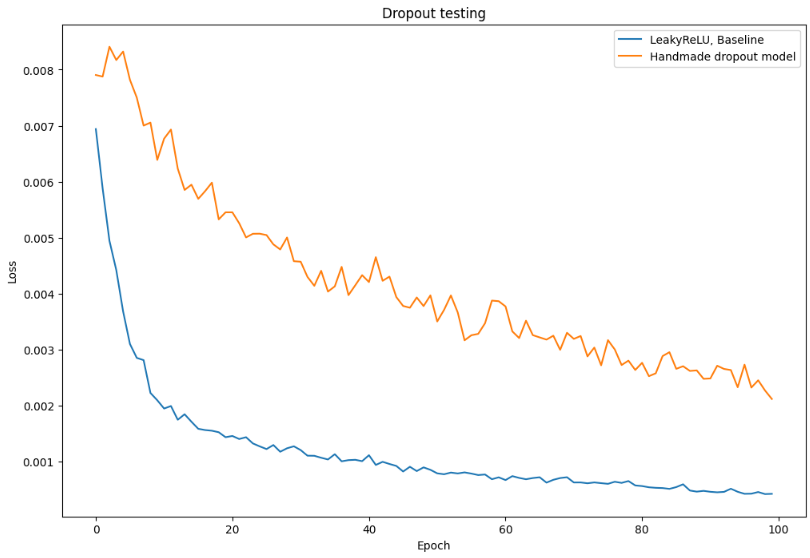

In [ ]:
if False:
  d1,d2,d3,d4 = read_data(1)
  X_train,X_test,Y_train,Y_test = randomize_datasets(d1,d2,d3,d4)

  m = Model([6,256,128,64,32,16,8,2], 0.1, 0.05) #Baseline

  m2 = tf.keras.Sequential()
  m2.add(tf.keras.layers.InputLayer(shape=(6,)))

  m2.add(tf.keras.layers.Dense(256))
  m2.add(tf.keras.layers.LeakyReLU(negative_slope=0.1))
  m2.add(tf.keras.layers.Dropout(rate=0.3))

  m2.add(tf.keras.layers.Dense(128))
  m2.add(tf.keras.layers.LeakyReLU(negative_slope=0.1))
  m2.add(tf.keras.layers.Dropout(rate=0.25))

  m2.add(tf.keras.layers.Dense(64))
  m2.add(tf.keras.layers.LeakyReLU(negative_slope=0.1))
  m2.add(tf.keras.layers.Dropout(rate=0.2))

  m2.add(tf.keras.layers.Dense(32))
  m2.add(tf.keras.layers.LeakyReLU(negative_slope=0.1))
  m2.add(tf.keras.layers.Dropout(rate=0.15))

  m2.add(tf.keras.layers.Dense(16))
  m2.add(tf.keras.layers.LeakyReLU(negative_slope=0.1))

  m2.add(tf.keras.layers.Dense(8))
  m2.add(tf.keras.layers.LeakyReLU(negative_slope=0.1))

  m2.add(tf.keras.layers.Dense(2, activation=None))

  m2.compile(
      loss=tf.keras.losses.MSE, #Mean squared error
      optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.05)) #Gradient Descent with Momemtum

  m.train_and_evaluate(X_train,X_test,Y_train,Y_test,100,16)

  result = []
  for i in range(100):
    m2.fit(X_train,Y_train, batch_size=16)
    a = m2.evaluate(X_test, Y_test, batch_size=16)
    result.append(a)

  plt.figure(figsize=(12, 8))
  plt.title("Dropout testing")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.plot(m.testing_history, label = "LeakyReLU, Baseline")
  plt.plot(result, label = "Handmade dropout model")
  plt.legend()

# Test 7.1 Hyperparameter optimization
## Values tested:
 - learning_rates = [0.01, 0.1, 0.5]
 - momentums = [0.01, 0.1, 0.5]
 - batch_sizes = [8,16,64]


## Results:
### Number of occurances in top 10 performers:
- Learning_rate   0.01 = 0 | 0.1 = 3 | 0.5 = 7
- Momentum        0.01 = 2 | 0.1 = 1 | 0.5 = 7
- Batch size      8    = 5 | 16  = 4 | 64  = 1

Clearly high learning rates and momentums are favorized, while small batch sizes are better.

Batch size is good enough at 16.
Learning rate and momentum could do a second round of optimization.

*Should probably test adaptive learning rate sooner or later*

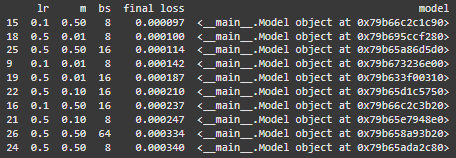

In [ ]:
#Test 7.1 Hyperparameter optimization

if False:
  d1,d2,d3,d4 = read_data(1)
  X_train,X_test,Y_train,Y_test = randomize_datasets(d1,d2,d3,d4)

  learning_rates = [0.01, 0.1, 0.5]
  momentums = [0.01, 0.1, 0.5]
  batch_sizes = [8,16,64]
  models = []
  i = 0
  for lr in learning_rates:
    for m in momentums:
      for bs in batch_sizes:
        i += 1
        print(i)
        model = Model([6,256,128,64,32,16,8,2], lr, m)
        model.train_and_evaluate(X_train,X_test,Y_train,Y_test,100,bs)
        a = [model, lr, m, bs]
        models.append(a)

  df = pd.DataFrame()
  df["lr"] = [a[1] for a in models]
  df["m"] = [a[2] for a in models]
  df["bs"] = [a[3] for a in models]

  df["final loss"] = [a[0].testing_history[-1] for a in models]
  df["model"] = [a[0] for a in models]

  winners = df.nsmallest(10, "final loss")

  print(winners)

# Test 7.2 Hyperparameter optimization second run

## Tested:
- learning_rates = [0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
- momentums = [0.25, 0.5, 0.75, 0.99]

## Results:
- learning_rates 0.3 = 2 | 0.5 = 1 | 0.7 = 2 | 1.0 = 2 | 1.5 = 1 | 2.0 = 2
- momentums 0.25 = 2 | 0.5 = 3 | 0.75 = 5 | 0.99 = 0

Learning rates are evenly distributed.
Momentums are clearly favoring 0.75
Visually there seems to be a trend that lower learning rates do better with low momentums and high learning rates do better with high momentums.
Very high momentum 0.99 is clearly really bad.

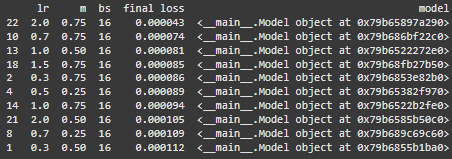

In [ ]:
#Test 7.2 Hyperparameter optimization second run

if False:
  d1,d2,d3,d4 = read_data(1)
  X_train,X_test,Y_train,Y_test = randomize_datasets(d1,d2,d3,d4)

  learning_rates = [0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
  momentums = [0.25, 0.5, 0.75, 0.99]
  batch_sizes = [16]
  models = []
  i = 0
  for lr in learning_rates:
    for m in momentums:
      for bs in batch_sizes:
        i += 1
        print(i)
        model = Model([6,256,128,64,32,16,8,2], lr, m)
        model.train_and_evaluate(X_train,X_test,Y_train,Y_test,100,bs)
        a = [model, lr, m, bs]
        models.append(a)

  df = pd.DataFrame()
  df["lr"] = [a[1] for a in models]
  df["m"] = [a[2] for a in models]
  df["bs"] = [a[3] for a in models]

  df["final loss"] = [a[0].testing_history[-1] for a in models]
  df["model"] = [a[0] for a in models]

  winners = df.nsmallest(10, "final loss")

  print(winners)

# Test 7.3 Hyperparameter optimization 3

## Tested
I've optimized also for the negative_slope parameter of the leaky_ReLU, this time.
  - learning_rates = [0.3, 0.5, 0.7, 1.0, 1.5]
  - momentums = [0.6, 0.75, 0.85]
  - negative_slopes = [0.01, 0.1, 0.25, 0.5, 0.75, 0.99]
## Results:
### Occurance of each value in top 10:
- learning_rates 0.3 = 1 | 0.5 = 3 | 0.7 = 2 | 1.0 = 3 | 1.5 = 1
- momentums 0.6 = 1 | 0.75 = 4 | 0.85 = 5
- negative_slopes 0.01 = 3 | 0.1 = 4 | 0.25 = 3 | 0.5 = 0 | 0.75 = 0 | 0.99 = 0

### Conclusion

No negative slopes above 0.25, quite evenly distributed, but more low values in top 5. ns = 0.1 seems like a good choice.

Most learning rates fall in range 0.5 - 1.0, seemingly more high values in top 5. I'd like to test adaptive learning rate next.

For momentums, almost all are between 0.75 - 0.85, in top 5 there is 4 x 0.85. Safe to safe its a 0.85 is a winner.

### Other Notes

I got a little impatient with this test. Should probably save it till after optimizing optimizer, loss function, etc.

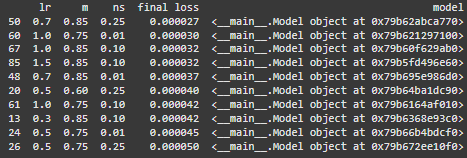

In [ ]:
#Test 7.3 Hyperparameter optimization third run

if False:
  d1,d2,d3,d4 = read_data(1)
  X_train,X_test,Y_train,Y_test = randomize_datasets(d1,d2,d3,d4)

  learning_rates = [0.3, 0.5, 0.7, 1.0, 1.5]
  momentums = [0.6, 0.75, 0.85]
  negative_slopes = [0.01, 0.1, 0.25, 0.5, 0.75, 0.99] #leakyReLU
  models = []
  i = 0
  for lr in learning_rates:
    for m in momentums:
      for ns in negative_slopes:
        i += 1
        print(i)
        model = Model([6,256,128,64,32,16,8,2], lr, m, leaky_rate = ns)
        model.train_and_evaluate(X_train,X_test,Y_train,Y_test,100,16)
        a = [model, lr, m, ns]
        models.append(a)

  df = pd.DataFrame()
  df["lr"] = [a[1] for a in models]
  df["m"] = [a[2] for a in models]
  df["ns"] = [a[3] for a in models]

  df["final loss"] = [a[0].testing_history[-1] for a in models]
  df["model"] = [a[0] for a in models]

  winners = df.nsmallest(10, "final loss")

  print(winners)

# Test 8.1 Adaptive Learning Rate implementation
## Tested:
- SGD with momentum (This is the default model until now.)
- Adaptive SGD (Decreasing LR, every epoch)
- Adam
- RMS Prop
## Results:
- Quite subtle differences, but there is potential?
- ADAM specifically has very fast convergence.
- ADAM and RMS more noisy on default settings.
- Hopefully with optimizing the hyperparameters, ADAM and RMS could beat SGD

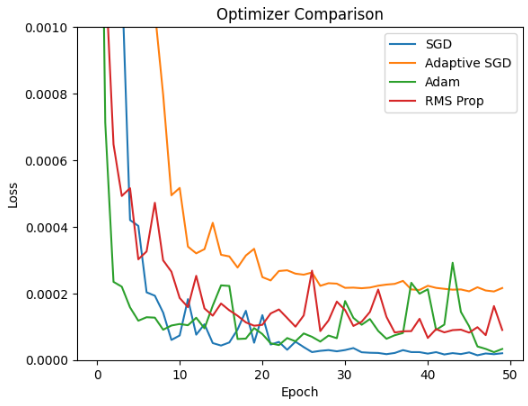

In [ ]:
#Test 8.1 Optimizing the optimizer, trying different optimizers

if False:
  d1,d2,d3,d4 = read_data(1)
  X_train,X_test,Y_train,Y_test = randomize_datasets(d1,d2,d3,d4)

  models = [
  Model([6,256,128,64,32,16,8,2], 1.0, 0.85, optimizer="sgd"),
  Model([6,256,128,64,32,16,8,2], 1.5, 0.85, optimizer="a_sgd"),
  Model([6,256,128,64,32,16,8,2], 0.001, 0.85, optimizer="adam"),
  Model([6,256,128,64,32,16,8,2], 0.001, 0.85, optimizer="rms_prop"),
  ]

  for m in models:
    m.train_and_evaluate(X_train,X_test,Y_train,Y_test,50,16)

  history_array = [m.testing_history for m in models]
  labels = ["SGD","Adaptive SGD","Adam","RMS Prop"]

  plot_array_of_histories(history_array,"Optimizer Comparison", labels)

# Test 8.2 Different loss functions
## Theory:
https://medium.com/@dancerworld60/maximizing-model-performance-exploring-the-different-types-of-loss-functions-8c3aa46e2a8f
https://www.tensorflow.org/api_docs/python/tf/keras/losses

- MSE (Mean Squared Error): Bad with outliers. Very simple and effective otherwise.
- MAE (Mean Absolute Error): More robust to outliers. Less effective for the same reason which is lack of squared term.
- Huber: A mix of MSE and MAE. Another hyperparameter delta which "classifies" sample as outlier or non-outlier, then uses MSE or MAE for the particular sample.
- MSLE (Mean Squared Logarithmic Error): Found this on tensorflow documentation page. Not many sources speak about this, but I left it in because why not.

## Results:
MSE is clearly a winner. I think that this is because of the lack of outliers in the dataset, due to its artificial source. Others should have better robustness to outliers, but also lower convergence so the results are expected.
Lets introduce outliers to the dataset to see how the loss functions respond.


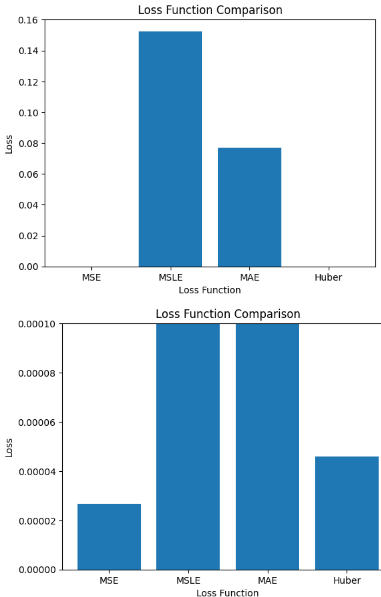

In [ ]:
#Test 8.2 Different loss functions

if False:
  d1,d2,d3,d4 = read_data(1)
  X_train,X_test,Y_train,Y_test = randomize_datasets(d1,d2,d3,d4)

  models = [
  Model([6,256,128,64,32,16,8,2], 1.0, 0.85, loss="mse"),
  Model([6,256,128,64,32,16,8,2], 1.0, 0.85, loss="msle"),
  Model([6,256,128,64,32,16,8,2], 1.0, 0.85, loss="mae"),
  Model([6,256,128,64,32,16,8,2], 1.0, 0.85, loss="huber"),
  ]

  for m in models:
    m.train_and_evaluate(X_train,X_test,Y_train,Y_test,50,16)

  #Cannot compare losses directly, calculate mse of the models predictions.
  predictions = np.array([m.model.predict(X_test) for m in models])
  losses = [np.mean((pred-Y_test)**2) for pred in predictions]
  print(losses)


  plt.bar([0,1,2,3],losses)
  plt.xticks([0,1,2,3],["MSE","MSLE","MAE","Huber"])
  plt.xlabel("Loss Function")
  plt.ylabel("Loss")
  plt.title("Loss Function Comparison")
  plt.show()

  plt.bar([0,1,2,3],losses)
  plt.xticks([0,1,2,3],["MSE","MSLE","MAE","Huber"])
  plt.xlabel("Loss Function")
  plt.ylabel("Loss")
  plt.ylim(0,0.0001)
  plt.title("Loss Function Comparison")
  plt.show()

# Test 8.2.2 Adding outliers to dataset

To test the alleged robustness to outliers of the other loss functions I swapped 2 values in the training set to extreme outliers.
  - X_train.iloc[5] = [12,5,9,4,15,10]
  - Y_train.iloc[92] = [40, 26]

## Results

As predicted by the theory, MAE and Huber have way smaller loss than MSE. Great.

Now would a real robotic arm have outliers in the dataset in the real world? Umm probably no, not to this extent. I would imagine the team reposible for the dataset did a really poor job if thats the case. Of course there are many other applications where outliers are a important consideration, but also there are other methods to dealing with them. In our case MSE is good enough, in a real setting maybe Huber with optimized delta should be considered.

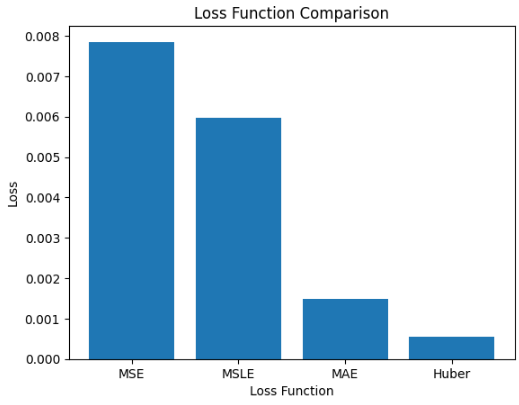

In [ ]:
#Test 8.2.2 Loss functions: adding some outliers.

if False:
  d1,d2,d3,d4 = read_data(1)
  X_train,X_test,Y_train,Y_test = randomize_datasets(d1,d2,d3,d4)

  models = [
  Model([6,256,128,64,32,16,8,2], 0.1, 0.085, loss="mse"),
  Model([6,256,128,64,32,16,8,2], 0.1, 0.085, loss="msle"),
  Model([6,256,128,64,32,16,8,2], 0.1, 0.085, loss="mae"),
  Model([6,256,128,64,32,16,8,2], 0.1, 0.085, loss="huber"),
  ]

  #add some artificial outliers
  X_train.iloc[5] = [12,5,9,4,15,10]
  Y_train.iloc[92] = [40, 26]

  for m in models:
    m.train_and_evaluate(X_train,X_test,Y_train,Y_test,50,16)

  #Cannot compare losses directly, calculate mse of the models predictions.
  predictions = np.array([m.model.predict(X_test) for m in models])
  losses = [np.mean((pred-Y_test)**2) for pred in predictions]
  print(losses)


  plt.bar([0,1,2,3],losses)
  plt.xticks([0,1,2,3],["MSE","MSLE","MAE","Huber"])
  plt.xlabel("Loss Function")
  plt.ylabel("Loss")
  plt.title("Loss Function Comparison")
  plt.show()

# Test 9: Testing different robots

## Results:
The performance is not great, not bad.

For r2 most of the points make sense, some pairs are a little bit off but nothing serious.

For r3 many points make sense, but some pairs have lost eachother completely.

For r5, alot of points have lost their pair entirely. 

The model is working fine but its outputing rough estimatates, 1000 samples is clearly not enough for the 3 joint and 5 joint robot.


I have a suspicion that optimizing the hyperparameters only on the 2j robot is a problem.
### Conclusion: To small dataset...


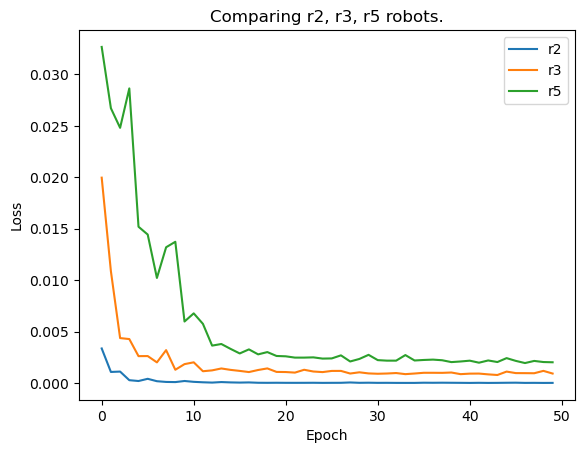

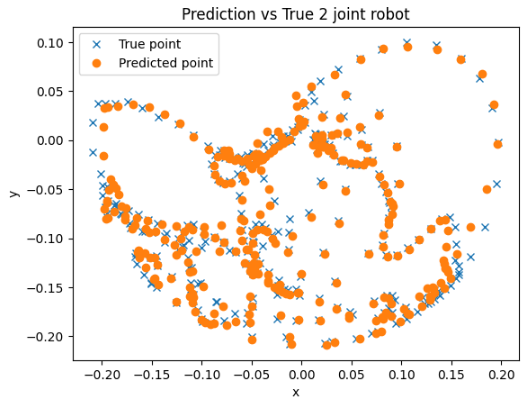

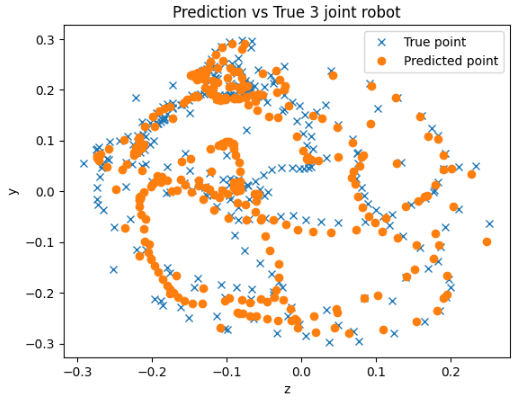

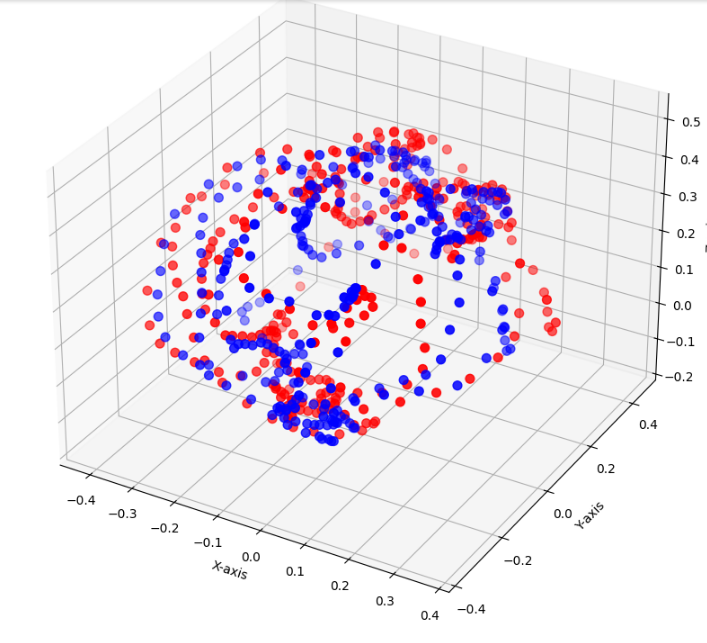

In [ ]:
#Test 9. Lets try out the r3 and r5 robot.

if False:
  d1,d2,d3,d4 = read_data(1)
  X2_train,X2_test,Y2_train,Y2_test = randomize_datasets(d1,d2,d3,d4)

  d1,d2,d3,d4 = read_data(2)
  X3_train,X3_test,Y3_train,Y3_test = randomize_datasets(d1,d2,d3,d4)

  d1,d2,d3,d4 = read_data(3)
  X5_train,X5_test,Y5_train,Y5_test = randomize_datasets(d1,d2,d3,d4,True)



  models = [
  Model([6,256,128,64,32,16,8,2], 1.0, 0.85),
  Model([9,256,128,64,32,16,8,2], 1.0, 0.85),
  Model([15,256,128,64,32,16,8,3], 1.0, 0.85),
  ]


  models[0].train_and_evaluate(X2_train,X2_test,Y2_train,Y2_test,50,16)
  models[1].train_and_evaluate(X3_train,X3_test,Y3_train,Y3_test,50,16)
  models[2].train_and_evaluate(X5_train,X5_test,Y5_train,Y5_test,50,16)

  labels = ["r2","r3","r5"]
  loss_history = [models[i].testing_history for i in range(3)]

  plot_array_of_histories(loss_history, "Comparing r2, r3, r5 robots.", labels)


  p0 = models[0].model.predict(X2_test)
  p1 = models[1].model.predict(X3_test)
  p2 = models[2].model.predict(X5_test)

  plt.figure()
  plt.title("Prediction vs True 2 joint robot")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.plot(Y2_test.iloc[:,0],Y2_test.iloc[:,1],"x", label = "True point")
  plt.plot(p0[:,0],p0[:,1],"o", label = "Predicted point")
  plt.legend()

  plt.figure()
  plt.title("Prediction vs True 3 joint robot")
  plt.xlabel("z")
  plt.ylabel("y")
  plt.plot(Y3_test.iloc[:,0],Y3_test.iloc[:,1],"x", label = "True point")
  plt.plot(p1[:,0],p1[:,1],"o", label = "Predicted point")
  plt.legend()

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111, projection="3d")


  ax.scatter(Y5_test.iloc[:,0],Y5_test.iloc[:,1],Y5_test.iloc[:,2], color="red", s=50, label="True Points")
  ax.scatter(p2[:,0],p2[:,1],p2[:,2], color="blue", s=50, label="Predicted Points")

  ax.set_xlabel("X-axis")
  ax.set_ylabel("Y-axis")
  ax.set_zlabel("Z-axis")
  ax.set_title("3D Single Point Plot")
  ax.legend()
  plt.show()


#Inverse Kinematics and Mujoco

This is my first experience with mujoco alot of the code is inspired from: https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb#scrollTo=Xqo7pyX-n72M

In [ ]:
import mujoco
import mediapy as media

""

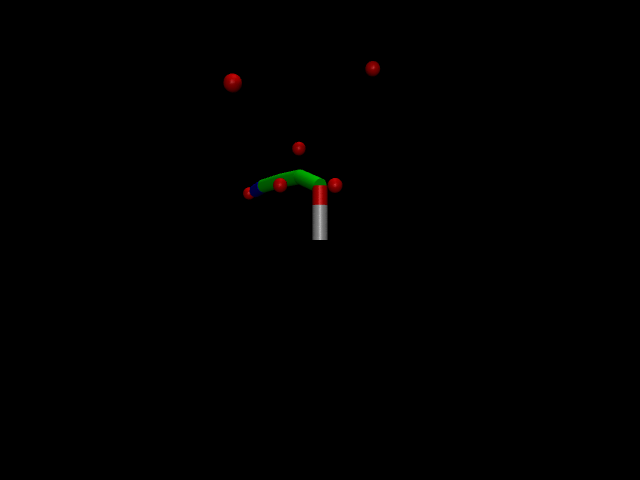

In [ ]:
#Modeling of the robotic arm
#Settings and structure heavly inspired by https://github.com/google-deepmind/mujoco/blob/main/model/humanoid/humanoid.xml

r5_arm = """
<mujoco>
  <option timestep=".0005">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" damping=".2" armature=".01" limited="true" solimplimit="0 .99 .01"/>
    <geom type="cylinder" condim="1" friction=".7" solimp=".9 .99 .003" solref=".015 1" group="1" density="1000" size="0.02"/>
    <motor ctrlrange="-1 1" ctrllimited="true"/>
  </default>

  <worldbody>
    <light pos="0 -.4 1"/>
    <light pos="0 +.4 1"/>

    <body name="goal1" pos="0.14 0.04 0.455">
      <geom type="sphere" size="0.02" rgba="1 0 0 1"/>
    </body>

    <body name="goal2" pos="-0.23 0.381 0.151">
      <geom type="sphere" size="0.02" rgba="1 0 0 1"/>
    </body>

    <body name="goal3" pos="-0.188 -0.252 0.338">
      <geom type="sphere" size="0.02" rgba="1 0 0 1"/>
    </body>

    <body name="goal4" pos="-0.062 0.201 0.268">
      <geom type="sphere" size="0.02" rgba="1 0 0 1"/>
    </body>

    <body name="goal5" pos="0.04  0.04  0.145">
      <geom type="sphere" size="0.02" rgba="1 0 0 1"/>
    </body>

    <body name="goal6" pos="-0.11   0.1  0.151">
      <geom type="sphere" size="0.02" rgba="1 0 0 1"/>
    </body>


    <camera name="fixed" pos="0 -1.5 0" xyaxes="1 0 0 0 0 1"/>

    <body name="Base" pos="0 0 0">
      <geom fromto="0 0 0 0 0 0.09" rgba="0.8 0.8 0.8 1"/>

      <body name="1" pos="0 0 0.09">
        <joint name="1" type="hinge" axis="0 0 1" range="-90 90"/>
        <geom fromto="0 0 0 0 0 0.05" rgba="1 0 0 1" density="1000"/>

        <body name="2" pos="0 0 0.05">
          <joint name="2" type="hinge" axis="0 1 0" range="-90 90"/>
          <geom fromto="0 0 0 0 0 0.1" rgba="0 1 0 1" density="1000"/>

          <body name="3" pos="0 0 0.1">
            <joint name="3" type="hinge" axis="0 1 0" range="-90 90" />
            <geom fromto="0 0 0 0 0 0.1" rgba="0 1 0 1" density="1000"/>


            <body name="4" pos="0 0 0.1">
              <joint name="4" type="hinge" axis="0 1 0" range="-90 90"/>
              <geom fromto="0 0 0 0 0 0.1" rgba="0 1 0 1" density="1000"/>

              <body name="5" pos="0 0 0.1">
                <joint name="5" type="hinge" axis="1 0 0" range="-90 90"/>
                <geom fromto="0 0 0 0 0 0.1" rgba="0 0 1 1" density="1000"/>
                <body name="tip" pos="0 0 0.1">
                </body>
              </body>
            </body>
          </body>
        </body>
      </body>
    </body>
  </worldbody>

  <actuator>
  <motor joint="1" ctrlrange="-1 1" gear="10"/>
  <motor joint="2" ctrlrange="-1 1" gear="10"/>
  <motor joint="3" ctrlrange="-1 1" gear="10"/>
  <motor joint="4" ctrlrange="-1 1" gear="10"/>
  <motor joint="5" ctrlrange="-1 1" gear="10"/>
  </actuator>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(r5_arm)
data = mujoco.MjData(model)
height = 480
width = 640

data.joint("1").qpos = -0.957
data.joint("2").qpos = -1.244
data.joint("3").qpos = -0.351
data.joint("4").qpos = -0.048
data.joint("5").qpos = -0.264

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, camera="fixed")

  media.show_image(renderer.render())

# Mini Test: 1k vs 10k sample dataset.

No suprises here, 10k samples wins by a good margin. This will help the the inverse kinematics alot.

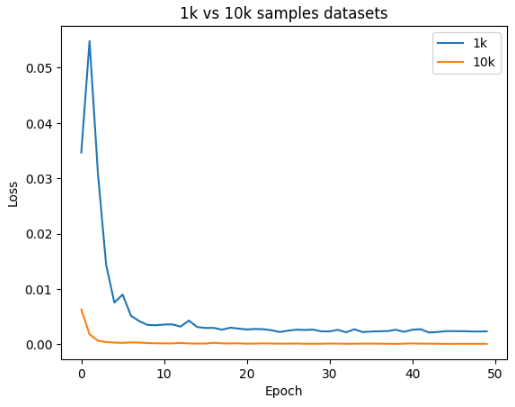

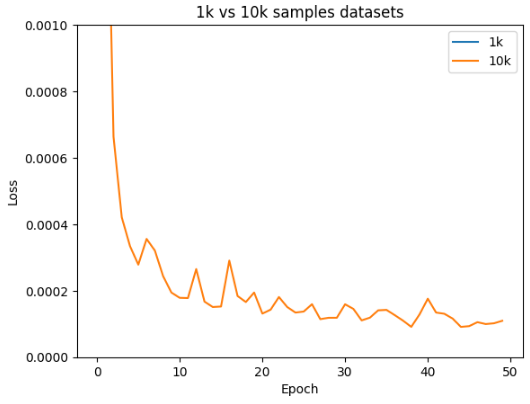

In [ ]:
#Train and save model for inverse kinematics
#I should"ve implemented this earlier...

#Train & Save
if False:
  d1,d2,d3,d4 = read_data(3, size=10000)
  X5_train,X5_test,Y5_train,Y5_test = randomize_datasets(d1,d2,d3,d4,True)

  m10k = Model([15,256,128,64,32,16,8,3], 1.0, 0.85)
  m10k.train_and_evaluate(X5_train, X5_test, Y5_train, Y5_test, 50, 16)

  d1,d2,d3,d4 = read_data(3, size=1000)
  X5_train,X5_test,Y5_train,Y5_test = randomize_datasets(d1,d2,d3,d4,True)

  m1k = Model([15,256,128,64,32,16,8,3], 1.0, 0.85)
  m1k.train_and_evaluate(X5_train, X5_test, Y5_train, Y5_test, 50, 16)

  m10k.model.save_weights("10k_model.weights.h5")
  m1k.model.save_weights("1k_model.weights.h5")

  #-----------------------------------------
  #Compare 1k samples vs 10 samples
  if True:
     a = [m1k.testing_history, m10k.testing_history]
     plot_array_of_histories(a, "1k vs 10k samples datasets", ["1k", "10k",])
     plot_array_of_histories(a, "1k vs 10k samples datasets", ["1k", "10k",], ylim=0.001)

#Load model
if True:
  m1k = Model([15,256,128,64,32,16,8,3], 1.0, 0.85)
  m10k = Model([15,256,128,64,32,16,8,3], 1.0, 0.85)

  m1k.model.load_weights("1k_model.weights.h5")
  m10k.model.load_weights("10k_model.weights.h5")




C:\Users\kacwi\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
#Functions for 5joint jacobians.

d1,d2,d3,d4 = read_data(3, size=1000)
X5_train,X5_test,Y5_train,Y5_test = randomize_datasets(d1,d2,d3,d4,True)

def fk5(model, X_sample):
  t = tf.reshape(X_sample, shape=(1,15))
  out = model.model(t)
  return tf.reshape(out, shape=(3,))

@tf.function
def model_jacobian5(X_sample,model):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(X_sample)
    y = fk5(model, X_sample)
  return tape.jacobian(y,X_sample)

def anglesToX(a):
  a = a.numpy().reshape(-1)
  return np.array([a[0], a[1],a[2],a[3],a[4],
                   np.sin(a[0]), np.sin(a[1]), np.sin(a[2]), np.sin(a[3]), np.sin(a[4]),
                   np.cos(a[0]), np.cos(a[1]), np.cos(a[2]), np.cos(a[3]), np.cos(a[4])])

def ik(initial_angles, p_desired, model):

  #p_0 = fk5(model, current_X)
  #p_1 = fk5(model, current_X + dX)
  #e = tf_norm(fk5(model, current_X + dX)-p_desired)

  current_angles = tf.convert_to_tensor(initial_angles, dtype=tf.float64)
  current_angles = tf.reshape(current_angles, (-1, 1))
  p_desired = tf.convert_to_tensor(p_desired)
  q = 1
  best = None

  #My implementation of Newton–Raphson method from https://en.wikipedia.org/wiki/Inverse_kinematics
  for i in range(1000):

    #My model doesn't know what to do with angles above pi/2...
    #Try something radical -> if |angle| > pi/2 reset it to 0.
    current_angles = tf.where(tf.abs(current_angles) > (3.14 / 2), 0.0, current_angles)

    #Get position and error
    p_k = fk5(model, anglesToX(current_angles))
    error = tf.cast(p_desired - p_k, tf.float64)

    #Early termination
    if tf.norm(error) < 0.001:
      return current_angles
    
    #Save best guess
    if best == None:
      best = (current_angles, tf.norm(error))
    else:
      if tf.norm(error) < best[1]:
        best = (current_angles, tf.norm(error))
    
    #Pseudo Inverse Jacobian
    J = model_jacobian5(anglesToX(current_angles), model)
    J = J[:,:5]
    J_pi = tf.linalgpinv(J)

    #Update the prediction
    next_angles = current_angles + tf.matmul(J_pi, tf.reshape(error, (-1,1))) / (tf.norm(error)* 500)
    current_angles = next_angles

  return best[0] #return our best guess



In [ ]:
#Code for making basic animations from https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb#scrollTo=z-zoBCuBv2Xi

if False: #Animate Robot
  # setup
  n_seconds = 20
  framerate = 60  # Hz
  n_frames = int(n_seconds * framerate)
  frames = []
  height = 480
  width = 480

  #Setting initial state
  mujoco.mj_resetData(model, data)

  initial_angles = [3.14/3, 3.14/2, -3.14/2, -3.14/4, 3.14/3]
  desired_angles = initial_angles

  data.joint("1").qpos = initial_angles[0]
  data.joint("2").qpos = initial_angles[1]
  data.joint("3").qpos = initial_angles[2]
  data.joint("4").qpos = initial_angles[3]
  data.joint("5").qpos = initial_angles[4]


  data.joint("1").qvel = 0
  data.joint("2").qvel = 0
  data.joint("3").qvel = 0
  data.joint("4").qvel = 0
  data.joint("5").qvel = 0


  # simulate and record frames
  frame = 0
  sim_time = 0
  render_time = 0
  n_steps = 0
  eintegral = [0,0,0,0,0]
  with mujoco.Renderer(model, height, width) as renderer:
    for i in range(n_frames):

      #Update desired angles every hardcoded value.
      if i == 25:
        eintegral = [0,0,0,0,0]
        current_angles = [data.joint("1").qpos, data.joint("2").qpos, data.joint("3").qpos, data.joint("4").qpos, data.joint("5").qpos ]
        desired_angles = ik(current_angles, tf.cast(Y5_test.iloc[-1, :], tf.float32), m10k)

      if i == 200:
        eintegral = [0,0,0,0,0]
        print("Final pos vs solution:", data.body("tip").xpos, Y5_test.iloc[-1,:])
        current_angles = [data.joint("1").qpos, data.joint("2").qpos, data.joint("3").qpos, data.joint("4").qpos, data.joint("5").qpos ]
        desired_angles = ik(current_angles, tf.cast(Y5_test.iloc[-2, :], tf.float32), m10k)

      elif i == 400:
        eintegral = [0,0,0,0,0]
        print("Final pos vs solution:", data.body("tip").xpos, Y5_test.iloc[-2,:])
        current_angles = [data.joint("1").qpos, data.joint("2").qpos, data.joint("3").qpos, data.joint("4").qpos, data.joint("5").qpos ]
        desired_angles = ik(current_angles, tf.cast(Y5_test.iloc[-3, :], tf.float32), m10k)

      elif i == 600:
        eintegral = [0,0,0,0,0]
        print("Final pos vs solution:", data.body("tip").xpos, Y5_test.iloc[-3,:])
        current_angles = [data.joint("1").qpos, data.joint("2").qpos, data.joint("3").qpos, data.joint("4").qpos, data.joint("5").qpos ]
        desired_angles = ik(current_angles, tf.cast(Y5_test.iloc[-4, :], tf.float32), m10k)

      elif i == 800:
        eintegral = [0,0,0,0,0]
        print("Final pos vs solution:", data.body("tip").xpos, Y5_test.iloc[-4,:])
        current_angles = [data.joint("1").qpos, data.joint("2").qpos, data.joint("3").qpos, data.joint("4").qpos, data.joint("5").qpos ]
        desired_angles = ik(current_angles, tf.cast([0.04,  0.04,  0.145], tf.float32), m10k)

      elif i == 1000:
        eintegral = [0,0,0,0,0]
        print("Final pos vs solution:", data.body("tip").xpos, [0.14,  0.04,  0.045])
        current_angles = [data.joint("1").qpos, data.joint("2").qpos, data.joint("3").qpos, data.joint("4").qpos, data.joint("5").qpos ]
        desired_angles = ik(current_angles, tf.cast([-0.11,   0.1,  0.151], tf.float32), m10k)

      while data.time * framerate < i:

        #Simple PI-Regulator
        #Only the joints fighting gravity need intergral effect 

        joints = ["1", "2", "3", "4", "5"]
        e = [desired_angles[i] - data.joint(joints[i]).qpos for i in range(5)]
        eintegral = [eintegral[j] + e[j] for j in range(5)]

        data.ctrl[0] = 0.2*e[0]
        data.ctrl[1] = 1.1*e[1] + 0.0001*eintegral[1]
        data.ctrl[2] = 1*e[2] + 0.0001*eintegral[2]
        data.ctrl[3] = 0.85*e[3] + 0.0001*eintegral[3]
        data.ctrl[4] = 0.2*e[4]

        tic = time.time()
        mujoco.mj_step(model, data)
        sim_time += time.time() - tic
        n_steps += 1
      tic = time.time()
      renderer.update_scene(data, "fixed")
      frame = renderer.render()
      render_time += time.time() - tic
      frames.append(frame)

  # print timing and play video
  step_time = 1e6*sim_time/n_steps
  step_fps = n_steps/sim_time
  print(f"simulation: {step_time:5.3g} μs/step  ({step_fps:5.0f}Hz)")
  frame_time = 1e6*render_time/n_frames
  frame_fps = n_frames/render_time
  print(f"rendering:  {frame_time:5.3g} μs/frame ({frame_fps:5.0f}Hz)")
  print("\n")

  # show video
  print("Final pos vs solution:", data.body("tip").xpos, [-0.23,   0.1,  0.151])
  media.show_video(frames, fps=framerate)


# Final Video Comments:

Much better performance than expected. The robot deals with the first 4 points really well. As for the last two they are clearly outside of its working area, but I wanted to see how it will respond to it anyway.

# Conclusion

In this project I've successfuly implemented a neural model based method of controlling a robotic arm in 3D.

I experimented alot with different configurations of neural networks and different variations of hyperparameters.

There are several things, which could use some more work. Firstly there were alot of test which were cut shorter than I'd like due to the limited scope of the project. Different configuration of ensambles, optimized hyperparameters for other optimizers, and optimization for other robots than r2, are things which come to mind. 

One interesting idea I've come up is trying out a autoencoder like structure to solve the inverse kinematics problem.

I.E would it be possible to train an autoencoder like network which works something like this: joint angles -> end position -> joint angles? And then of course use the decoder part for IK.
I imagine there would be some problems with the multiple possible solutions of the inverse kinematics, 
and also after seaching google, I found out this is not exactly a new idea...

But I do think it would be an interesting experiment nevertheless.

Overall, I have learned alot through this homework, and gained a good amount of experience with programming and machine learning. I've also found the project really interesting, and I'd defintely want to dive deeper into machine learning into the future.